# Practical Three: Spatial modelling in R

This practical looks at some of the problems of fitting statistical models to spatial data, using the statistical software R. We are going to be covering a lot of ground but:

> Do **not** panic.

The intention in this practical is to show some options that are available for spatial models in R. The main thing is to think about what the options are available, not in learning how to do it all in one afternoon!

There are a lot of other resources out there to provide more detail and I *highly* recommend this:

[https://rspatial.org/raster/analysis/index.html](https://rspatial.org/raster/analysis/index.html)

## Required packages

As with species distribution mdelling, there are many packages used in spatial modelling. There is an intimidating complete list of topics and packages here:

[https://CRAN.R-project.org/view=Spatial](https://CRAN.R-project.org/view=Spatial)

This practical requires the following packages, which should all be installed in the RStudio Cloud project, but which you will need to install if you are using your own computer.

```r
install.packages('ncf')
install.packages('raster')
install.packages('sf')
install.packages('SpatialPack') # For clifford test
install.packages('spdep') # Spatial dependence
install.packages('spatialreg')
install.packages('nlme') # GLS
install.packages('spgwr')
install.packages('spmoran')
```

As usual, you then need to load the packages:

In [1]:
library(ncf)
library(raster)
library(sf)
library(spdep)
library(SpatialPack)
library(spatialreg)
library(nlme)
library(spgwr)
library(spmoran)

Loading required package: sp



Linking to GEOS 3.7.2, GDAL 2.4.2, PROJ 5.2.0



Loading required package: spData



To access larger datasets in this package, install the spDataLarge
package with: `install.packages('spDataLarge',
repos='https://nowosad.github.io/drat/', type='source')`



Loading required package: fastmatrix



Loading required package: Matrix




Attaching package: ‘Matrix’




The following object is masked from ‘package:fastmatrix’:

    lu




Registered S3 methods overwritten by 'spatialreg':
  method                   from 
  residuals.stsls          spdep
  deviance.stsls           spdep
  coef.stsls               spdep
  print.stsls              spdep
  summary.stsls            spdep
  print.summary.stsls      spdep
  residuals.gmsar          spdep
  deviance.gmsar           spdep
  coef.gmsar               spdep
  fitted.gmsar             spdep
  print.gmsar              spdep
  summary.gmsar            spdep
  print.summary.gmsar      spdep
  print.lagmess            spdep
  summary.lagmess          spdep
  print.summary.lagmess    spdep
  residuals.lagmess        spdep
  deviance.lagmess         spdep
  coef.lagmess             spdep
  fitted.lagmess           spdep
  logLik.lagmess           spdep
  fitted.SFResult          spdep
  print.SFResult           spdep
  fitted.ME_res            spdep
  print.ME_res             spdep
  print.lagImpact          spdep
  plot.lagImpact           spdep
  summary.lagImpact      


Attaching package: ‘spatialreg’




The following objects are masked from ‘package:spdep’:

    anova.sarlm, as_dgRMatrix_listw, as_dsCMatrix_I, as_dsCMatrix_IrW,
    as_dsTMatrix_listw, as.spam.listw, bptest.sarlm, can.be.simmed,
    cheb_setup, coef.gmsar, coef.sarlm, coef.spautolm, coef.stsls,
    create_WX, deviance.gmsar, deviance.sarlm, deviance.spautolm,
    deviance.stsls, do_ldet, eigen_pre_setup, eigen_setup, eigenw,
    errorsarlm, fitted.gmsar, fitted.ME_res, fitted.sarlm,
    fitted.SFResult, fitted.spautolm, get.ClusterOption,
    get.coresOption, get.mcOption, get.VerboseOption,
    get.ZeroPolicyOption, GMargminImage, GMerrorsar, griffith_sone,
    gstsls, Hausman.test, HPDinterval.lagImpact, impacts, intImpacts,
    Jacobian_W, jacobianSetup, l_max, lagmess, lagsarlm, lextrB,
    lextrS, lextrW, lmSLX, logLik.sarlm, logLik.spautolm, LR.sarlm,
    LR1.sarlm, LR1.spautolm, LU_prepermutate_setup, LU_setup,
    Matrix_J_setup, Matrix_setup, mcdet_setup, MCMCsamp, ME, mom_calc,
    mom_calc_int2, moments_setu


Attaching package: ‘nlme’




The following object is masked from ‘package:raster’:

    getData




NOTE: This package does not constitute approval of GWR
as a method of spatial analysis; see example(gwr)



## The dataset

We will use some data taken from a paper that looked at trying to predict what limits species ranges:

> McInnes, L., Purvis, A., & Orme, C. D. L. (2009). Where do species' geographic ranges stop and why? Landscape impermeability and the Afrotropical avifauna. Proceedings of the Royal Society Series B - Biological Sciences, 276(1670), 3063-3070. [http://doi.org/10.1098/rspb.2009.0656](http://doi.org/10.1098/rspb.2009.0656)

We won't actually be looking at range edges but we're going to use four variables taken from the data used in this paper. The data is all saved as GeoTIFF files, so we're starting with raster data. The files cover the Afrotropics and are all projected in the Behrmann equal area projection. This is a cylindrical equal area projection with a *latitude of true scale* of 30°. What that *means* is that distances on the projected map correspond to distances over the surface of the Earth at ±30° of latitude.

That is the reason for the odd resolution of this data: 96.48627 km. The circumference of the Earth at ±30° - the length of the parallels at ±30° - is ~ 34735.06 km and this resolution splits the map into 360 cells giving a resolution comparable to a degree longitude at 30° N. Unlike a one degree resolution grid, however, these grid cells all cover an **equal area** on the ground ($96.48627 \times 96.48627 = 9309.6 \text{km}^2$, roughly the land area of Cyprus).

The variables for each grid cell are:

* the avian species richness across the Afrotropics,
* the mean elevation,
* the average annual temperature, and
* the average annual actual evapotranspiration.

### Loading the data

In [2]:
# load the four variables from their TIFF files
rich <- raster('data/avian_richness.tif')
aet <- raster('data/mean_aet.tif')
temp <- raster('data/mean_temp.tif')
elev <- raster('data/elev.tif')

It is always a good idea to look at the details of the data. One key skills in being a good scientist and statistician is in looking at data and models and saying: 

> Uh, that doesn't make any sense, something has gone wrong.

So we will quickly use some techniques to explore the data we have just loaded. 

1. We will look at the summary of the richness data. That shows us the dimensions of the data, resolution, extent and coordinate reference system and the range of the data: between 10 and 667 species per cell.

In [3]:
# Look at the details of the richness data
print(rich)

class      : RasterLayer 
dimensions : 75, 78, 5850  (nrow, ncol, ncell)
resolution : 96.48627, 96.48627  (x, y)
extent     : -1736.753, 5789.176, -4245.396, 2991.074  (xmin, xmax, ymin, ymax)
crs        : +proj=cea +lon_0=0 +lat_ts=30 +x_0=0 +y_0=0 +datum=WGS84 +units=km +no_defs +ellps=WGS84 +towgs84=0,0,0 
source     : avian_richness.tif 
names      : avian_richness 
values     : 10, 667  (min, max)



We can also plot maps the variables and think about the spatial patterns in each.

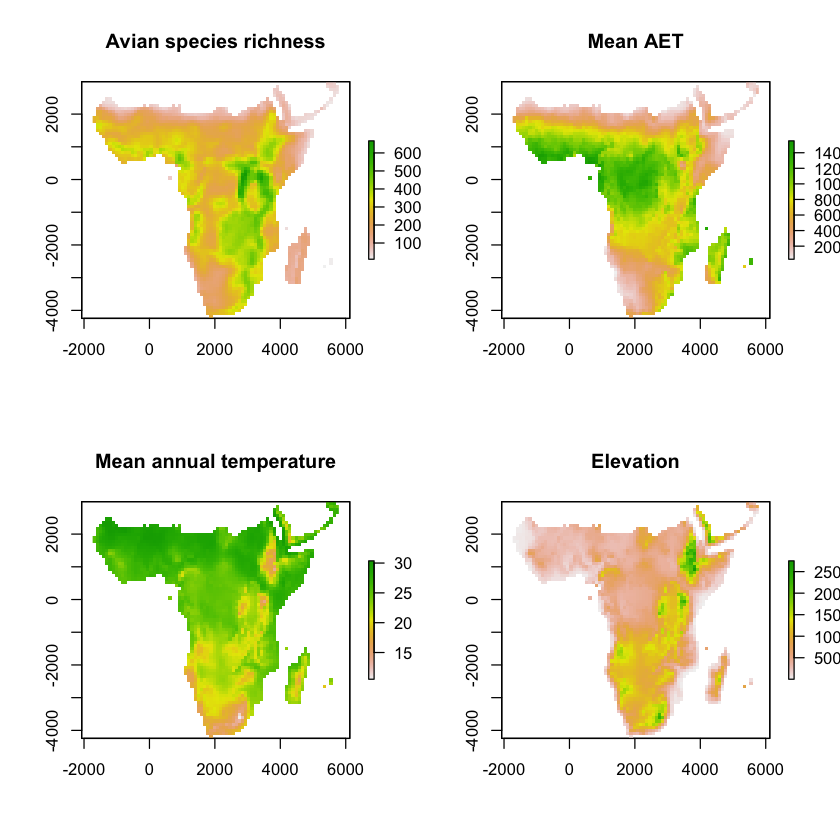

In [4]:
par(mfrow=c(2,2))
plot(rich, main='Avian species richness')
plot(aet, main='Mean AET')
plot(temp, main='Mean annual temperature')
plot(elev, main='Elevation')

We can use R to explore this data a bit further. We can use the `hist()` function to plot the distribution of the values in each variable, not just look at the minimum and maximum.

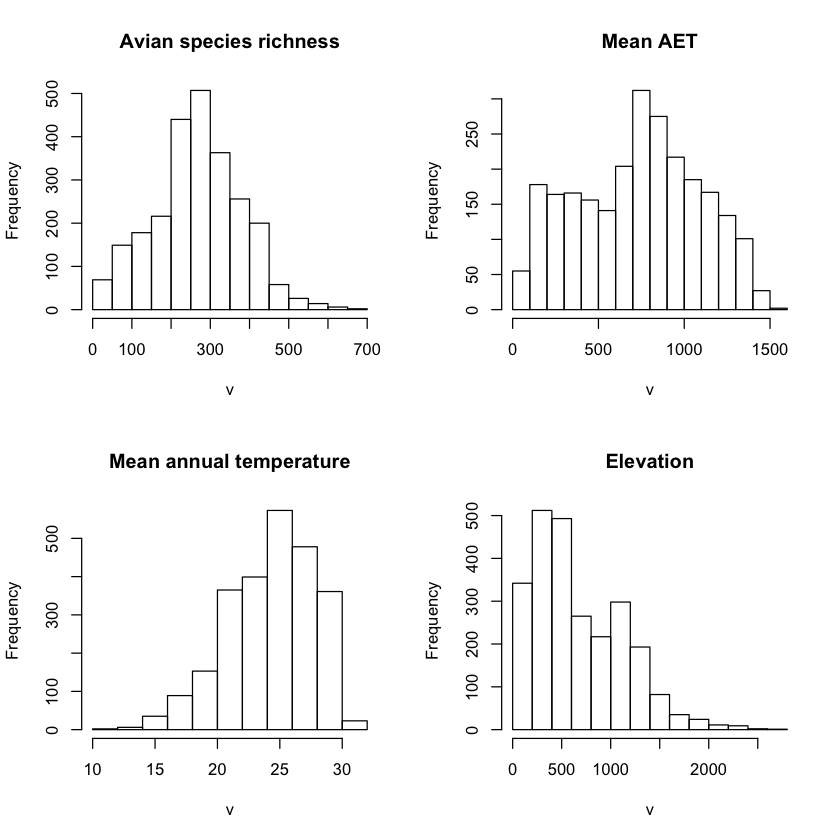

In [5]:
# split the figure area into a two by two layout
par(mfrow=c(2,2))
# plot a histogram of the values in each raster, setting nice 'main' titles
hist(rich, main='Avian species richness')
hist(aet, main='Mean AET')
hist(temp, main='Mean annual temperature')
hist(elev, main='Elevation')

### Formatting the data as a data frame 

We now have the data as rasters but some of the methods require the values in a data frame. We'll need to use two commands: 

First, `stack()` allows us to superimpose the four rasters into a single object. Note that this only works because all of these rasters have the same projection, extent and resolution. In your own use, you would need to use GIS to set up your data so it can be stacked like this.

In [6]:
# Stack the data
data_stack <- stack(rich, aet, elev, temp)
print(data_stack)

class      : RasterStack 
dimensions : 75, 78, 5850, 4  (nrow, ncol, ncell, nlayers)
resolution : 96.48627, 96.48627  (x, y)
extent     : -1736.753, 5789.176, -4245.396, 2991.074  (xmin, xmax, ymin, ymax)
crs        : +proj=cea +lon_0=0 +lat_ts=30 +x_0=0 +y_0=0 +datum=WGS84 +units=km +no_defs +ellps=WGS84 +towgs84=0,0,0 
names      : avian_richness,  mean_aet,      elev, mean_temp 
min values :        10.0000,   32.0600,    1.0000,   10.5246 
max values :       667.0000, 1552.6500, 2750.2800,   30.3667 



Second, `as()` allows us to convert an R object from one format to another. Here we convert to the `SpatialPixelDataFrame` format from the `sp` package. This is a useful format because it works very like a data frame, but identifies the geometry as pixels. Note that the names of the *variables in the data frame have been set from the original TIFF filenames*, not our variable names in R.

In [7]:
data_spdf <- as(data_stack, 'SpatialPixelsDataFrame')
summary(data_spdf)

Object of class SpatialPixelsDataFrame
Coordinates:
        min      max
x -1736.753 5789.176
y -4245.396 2991.074
Is projected: TRUE 
proj4string :
[+proj=cea +lon_0=0 +lat_ts=30 +x_0=0 +y_0=0 +datum=WGS84 +units=km
+no_defs +ellps=WGS84 +towgs84=0,0,0]
Number of points: 2484
Grid attributes:
   cellcentre.offset cellsize cells.dim
s1         -1688.510 96.48627        78
s2         -4197.153 96.48627        75
Data attributes:
 avian_richness     mean_aet            elev          mean_temp    
 Min.   : 10.0   Min.   :  32.06   Min.   :   1.0   Min.   :10.52  
 1st Qu.:202.0   1st Qu.: 439.70   1st Qu.: 317.7   1st Qu.:21.83  
 Median :269.5   Median : 754.59   Median : 548.8   Median :24.71  
 Mean   :268.4   Mean   : 732.07   Mean   : 672.0   Mean   :24.25  
 3rd Qu.:341.0   3rd Qu.: 996.60   3rd Qu.:1023.2   3rd Qu.:27.15  
 Max.   :667.0   Max.   :1552.65   Max.   :2750.3   Max.   :30.37  

We can also that into a `sf` object, which we have been using in previous practicals. These differ in how they represent the geometry:

* `SpatialPixelDataFrame`: this holds the data as values in *pixels*, so 'knows' that the values represents an area.
* `sf`: the default conversion here holds the data as values at a point.

In [8]:
data_sf <- st_as_sf(data_spdf)
print(data_sf)

Simple feature collection with 2484 features and 4 fields
Geometry type: POINT
Dimension:     XY
Bounding box:  xmin: -1736.753 ymin: -4245.396 xmax: 5789.176 ymax: 2991.074
CRS:           +proj=cea +lon_0=0 +lat_ts=30 +x_0=0 +y_0=0 +datum=WGS84 +units=km +no_defs +ellps=WGS84 +towgs84=0,0,0
First 10 features:
   avian_richness mean_aet     elev mean_temp                  geometry
1              55 157.4988  619.990   25.5596 POINT (5451.474 2942.831)
2              52 117.5050  353.648   26.7782  POINT (5547.96 2942.831)
3              44  93.1765  270.054   27.3340 POINT (5644.447 2942.831)
4              45  86.4079 1043.670   24.9595 POINT (3907.694 2846.345)
5              38 136.8711  353.393   27.2728 POINT (5451.474 2846.345)
6              50  99.2078  773.086   24.9603  POINT (5547.96 2846.345)
7              49 110.1031  610.546   25.6667 POINT (5644.447 2846.345)
8              38 122.4231  820.173   25.0142 POINT (5740.933 2846.345)
9              58  70.4857  294.331   28

```{admonition} Affine transformation sidebar
Just to show off `sf` a bit - and do something a bit more complex with `sf` objects - we can turn that point data into polygon data. Each cell is the centre of a cell with sides of ~96 km: we can use those points to define [affine transformations](https://r-spatial.github.io/sf/articles/sf3.html). This means we can create a template polygon that is the right size for the grid cells, centred on zero and then use the points to move them all into the right place.

This code is a little bit trickier! Also, if I'm being honest, a polygon grid isn't a great way to store raster data!
```

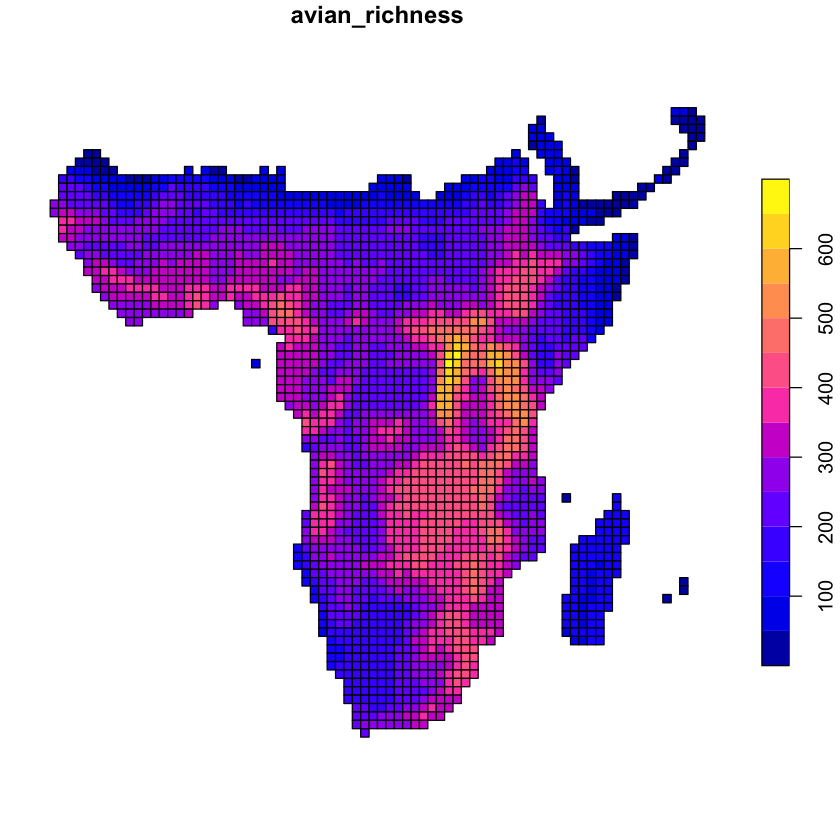

In [9]:
# Get the cell resolution
cellsize <- res(rich)[[1]]
# Make the template polygon
template <- st_polygon(list(matrix(c(-1,-1,1,1,-1,-1,1,1,-1,-1), ncol=2) * cellsize / 2))
# Add each of the data points to the template
polygon_data <- lapply(data_sf$geometry, function(pt) template + pt)
data_poly <- st_sf(avian_richness = data_sf$avian_richness, 
                   geometry=polygon_data)
plot(data_poly['avian_richness'])

### More data exploration

We now have new data structures that have spatial information and matches up the different variables across locations. 

We can still plot the data as a map and the images below show the difference between the `SpatialPixelsDataFrame` and the `sf` version of the data. The code has lots of odd options: this combination of settings avoids each plot command insisting on the layout it wants to use and lets us [control the layout of the plots](https://www.r-spatial.org/r/2016/03/08/plotting-spatial-grids.html).

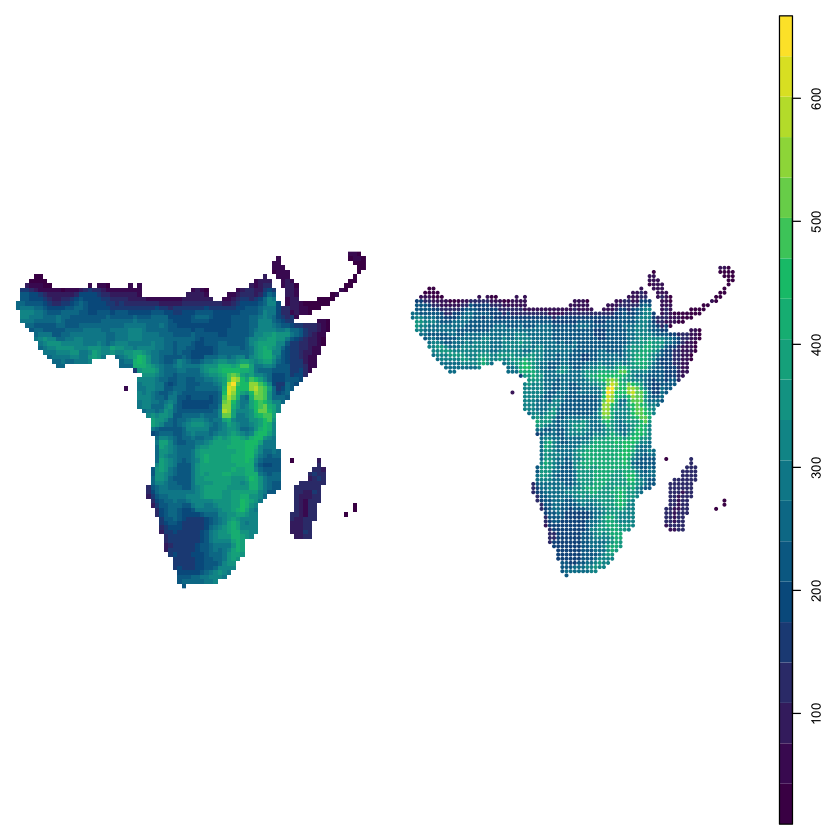

In [10]:
# Plot the richness data as point data
layout(matrix(1:3, ncol=3), widths=c(5,5,1))
plot(data_spdf['avian_richness'], col=hcl.colors(20), what='image')
plot(data_sf['avian_richness'], key.pos=NULL, reset=FALSE, main='', 
     pal=hcl.colors, cex=0.7, pch=20)
plot(data_spdf['avian_richness'], col=hcl.colors(20), what='scale')

We can also plot the variables against each other, by treating the new object as a data frame:

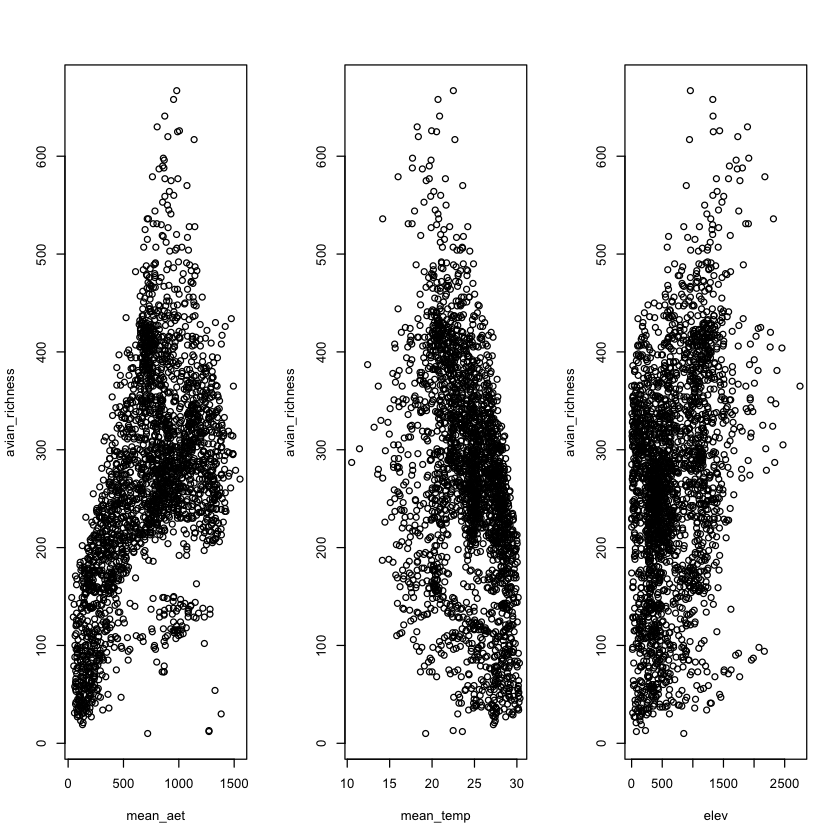

In [11]:
# Create three figures in a single panel
par(mfrow=c(1,3))
# Now plot richness as a function of each environmental variable
plot(avian_richness ~ mean_aet, data=data_sf)
plot(avian_richness ~ mean_temp, data=data_sf)
plot(avian_richness ~ elev, data=data_sf)

## Correlations and spatial data

A **correlation coefficient** is a standardised measure between -1 and 1 showing how much observations of two variables tend to co-vary. For a positive correlation, both variables tend to have high values in the same locations and low values in the same locations. Negative correlations show the opposite. Once you've calculated a correlation, you need to assess how strong that correlation is _given the amount of data you have_: it is easy to get large $r$ values in small datasets by chance.

However, correlation coefficients assume that the data points are independent and this is not true for spatial data. Nearby data points tend to be similar: if you are in a warm location, surrounding areas will also tend to be warm. One relatively simple way of removing this non-independence is to calculate the significance of tests as if you had fewer data points.

We will use this approach to  compare standard measures of correlation to spatially corrected ones. We need to load a new set of functions that implement a modification to the correlation test that accounts for spatial similarity, described in [this paper](https://jstor.org/stable/2532039). The modified test does not change the correlation statistic itself but calculates a new effective sample size and uses this in calculating the $F$ statistic.

In [12]:
# Use the modified.ttest function from SpatialPack
temp_corr <- modified.ttest(x=data_sf$avian_richness, y=data_sf$mean_temp, 
                            coords=st_coordinates(data_sf))
print(temp_corr)


Corrected Pearson's correlation for spatial autocorrelation

data: x and y ; coordinates: X and Y 
F-statistic: 5.1886 on 1 and 32.263 DF, p-value: 0.0295 
alternative hypothesis: true autocorrelation is not equal to 0
sample correlation: -0.3722


```{admonition} Other variables
Use this code to look at how the other explanatory variables  with bird richness. It is also worth looking at correlations between the explanatory variables!
```

## Neighbourhoods

One of the core concepts in many spatial statistical methods is the **neighbourhood** of cells. The neighbourhood of a cell defines a set of other cells that are connected to the focal cell, often with a given weight. The neighbourhood is one way of providing spatial structure to the statistical methods and there are many options for doing this. The `spdep` package provides a good guide (`vignette('nb')`) on the details, but we will look at two functions: `dnearneigh` and `knearneigh`.

### dnearneigh

We can use this function to find which cells are within a given distance of a focal point. We can also put a minimum distance to exclude nearby, but we will keep that at zero here. Working with raster data,where points are on an even grid, we can use this function to generate the **Rook** and **Queen** move neighbours. To do that we need to get the resolution of the raster and use that to set appropriate distances.

In [13]:
# Give dnearneigh the coordinates of the points and the distances to use
rook <- dnearneigh(data_sf, d1=0, d2=cellsize)
queen <- dnearneigh(data_sf, d1=0, d2=sqrt(2) * cellsize)

If we look at those in a bit more details we can see that they are very similar but  - surprise! - there are more cells linked as neighbours in `queen`. Using `head` allows us to see the row numbers in our data frame that are neighbours. We can also look at the number of neighbours in each set (the *cardinality*, hence the function name `card`). If we store that in our `data_sf` data frame, we can then visualise the number of neighbours.

```{code-block} R
print(rook)
```

```{code-block} R
head(rook, n=3)
```

```{code-block} R
print(queen)
```

```{code-block} R
head(queen, n=3)
```

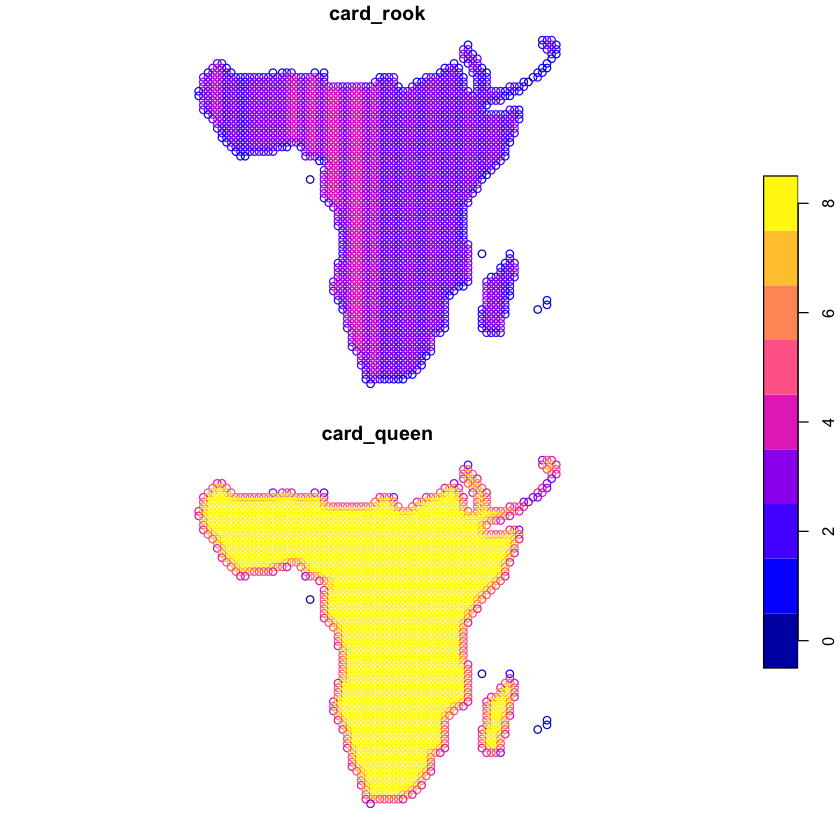

In [14]:
# Store the neighbourhood cardinalities in data_sf
data_sf$card_rook <- card(rook)
data_sf$card_queen <- card(queen)
# Look at the count of rook and queen neighbours for each point
plot(data_sf[c('card_rook', 'card_queen')], key.pos=4)

That does **not** look correct - we should not be seeing those stripes in central Africa with only two or three rook neighbours. The reason for this is using _exactly_ the resolution as our distance: minor rounding differences can lead to distance based measures going wrong, so it is once again **always a good idea to plot your data and check**!

```{admonition} Fix the neighbours
A simple solution here is just to make the distance very slightly larger. Do this and recreate the `rook` and `queen` neighbours. The new version should look like the figure below.
```

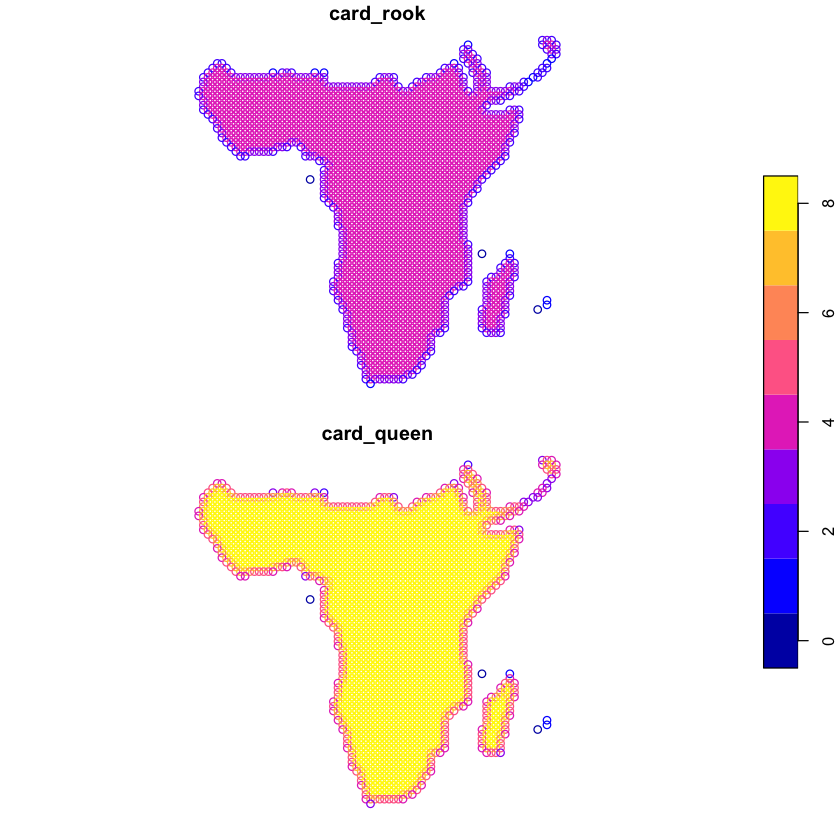

In [15]:
# Recreate the neighbour adding 1km to the distance
rook <- dnearneigh(data_sf, d1=0, d2=cellsize + 1)
queen <- dnearneigh(data_sf, d1=0, d2=sqrt(2) * cellsize + 1)
data_sf$card_rook <- card(rook)
data_sf$card_queen <- card(queen)
plot(data_sf[c('card_rook', 'card_queen')], key.pos=4)

### knearneigh

One thing to note in the details of `rook` and `queen` are the bits that say:

```
3 regions with no links:
1311 1817 2204 
```

These are points that have no other point within the provided distance. These are islands: São Tomé and Principe, Comoros, and Réunion - it just happens that Mauritius falls into two cells and so has itself as a neighbour. The `knearneigh` function ensures that all points have the same number of neighbours by looking for the $k$ closest locations. You end up with a matrix

In [16]:
knn <- knearneigh(data_sf, k=8)
# We have to look at the `nn` values in `knn` to see the matrix of neighbours
head(knn$nn, n=3)

[,1] [,2] [,3] [,4] [,5] [,6] [,7] [,8]
[1,] 5    2    6    3    11    7   12    8  
[2,] 6    3    1    7     5   11   12    8  
[3,] 7    2    6    8    12    1   11   13

### Spatial weights

The neighbourhood functions just give us sets of neighbours, and most spatial modelling functions require **weights** to be assigned to neighbours. In `spdep`, we need to use `nb2listw` to take our plain sets of neighbours and make them into weighted neighbour lists.

In [17]:
queen <- nb2listw(queen)

ERROR: Error in nb2listw(queen): Empty neighbour sets found


That didn't work! The error message is fairly clear (for R) - we **cannot** create weighted lists for locations with no neighbours. We have two choices here: 

1. Remove the points with no neighbours - given these are isolated offshore islands, this seems reasonable.
2. Use a neighbourhood system in which they are not isolated. We already have this using `knearneigh`, but you do have to ask yourself if a model that arbitrarily links offshore islands is realistic.

#### More data cleaning

It would be easy to use `subset` on `data_sf` to remove cells with zero neighbours, but we really should remove Mauritius as well (two cells with cardinality of 1). Unfortunately there is a coastal cell with a rook cardinality of 1 in the north of Madagascar, and that probably is reasonable to include! So, we will use a GIS operation.

In [18]:
# Polygon covering Mauritius
mauritius <- st_polygon(list(matrix(c(5000, 6000, 6000, 5000, 5000,
                                    0, 0, -4000, -4000, 0), 
                                    ncol=2)))
mauritius <- st_sfc(mauritius, crs=crs(data_sf, asText=TRUE))
# Remove the island cells with zero neighbours
data_sf <- subset(data_sf, card_rook > 0)
# Remove Mauritius
data_sf <- st_difference(data_sf, mauritius)

Warning message:
“attribute variables are assumed to be spatially constant throughout all geometries”


We do now need to recalculate our neighbourhood objects to use that reduced set of locations.

In [19]:
rook <- dnearneigh(data_sf, d1=0, d2=cellsize + 1)
queen <- dnearneigh(data_sf, d1=0, d2=sqrt(2) * cellsize + 1)
data_sf$card_rook <- card(rook)
data_sf$card_queen <- card(queen)
knn <- knearneigh(data_sf, k=8)

#### Calculating weights

There are several weighting styles and choosing different strategies obviously affects the resulting statistics. One option is **binary** weights (cells are either connected or not) but there are other options. Here we will use the default *row standardised* (`style='W'`), which just means that the neighbours of location all get the same weight but the sum of neighbour weights for location is always one.

Note that `knn` needs to be converted to the same format (`nb`) as the rook and queen neighbourhoods first.

In [20]:
rook <- nb2listw(rook, style='W')
queen <- nb2listw(queen, style='W')
knn <- nb2listw(knn2nb(knn), style='W')

## Spatial autocorrelation metrics

Spatial autocorrelation describes the extent to which points that are close together in space show similar values. It can be measured globally and locally - note that **global** here means *the whole of the dataset* and not the whole of the Earth. 

### Global spatial autocorrelation

There are a number of statistics that quantify the level of global spatial autocorrelation in a dataset. These statistics test if the dataset as a whole shows spatial autocorrelation.

We will be looking at the commonly used Moran's $I$ and Geary's $C$ statistics

* Moran's $I$ takes values between -1 and 1, with the central value of 0 showing that there is no spatial autocorrelation. Values close to -1 show strong negative autocorrelation, which is the unusual case that nearby cells have unexpectedly **different** values and values close to 1 show that nearby cells have unexpectedly **similar** values.

* Geary's $C$ scales the other way around. It is not perfectly correlated with Moran's $I$ but closely related.

In [21]:
moran_avian_richness <- moran.test(data_sf$avian_richness, rook)
print(moran_avian_richness)


	Moran I test under randomisation

data:  data_sf$avian_richness  
weights: rook    

Moran I statistic standard deviate = 64.66, p-value < 2.2e-16
alternative hypothesis: greater
sample estimates:
Moran I statistic       Expectation          Variance 
     0.9499254829     -0.0004035513      0.0002160130 



In [22]:
geary_avian_richness <- geary.test(data_sf$avian_richness, rook)
print(geary_avian_richness)


	Geary C test under randomisation

data:  data_sf$avian_richness 
weights: rook 

Geary C statistic standard deviate = 64.254, p-value < 2.2e-16
alternative hypothesis: Expectation greater than statistic
sample estimates:
Geary C statistic       Expectation          Variance 
     0.0468078533      1.0000000000      0.0002200701 



```{admonition} Variables and neighbours
Look to see if the different neighbourhood schemes increase or decrease spatial autocorrelation. Do all of the other three variables show significant spatial autocorrelation?
```

### Local spatial autocorrelation

We can also look at local indicators of spatial autocorrelation (LISA) to show areas of stronger or weaker similarity. These calculate a similar statistic but only within the neighbourhood around each cell and report back the calculated value for each cell, which we can then map. 

The `localmoran` function outputs a matrix of values. The columns contain observed $I$, the expected value, variance, $z$ statistics and $p$ value and the rows contain the location specific measures of each variable, so we can load them into `data_sf`.

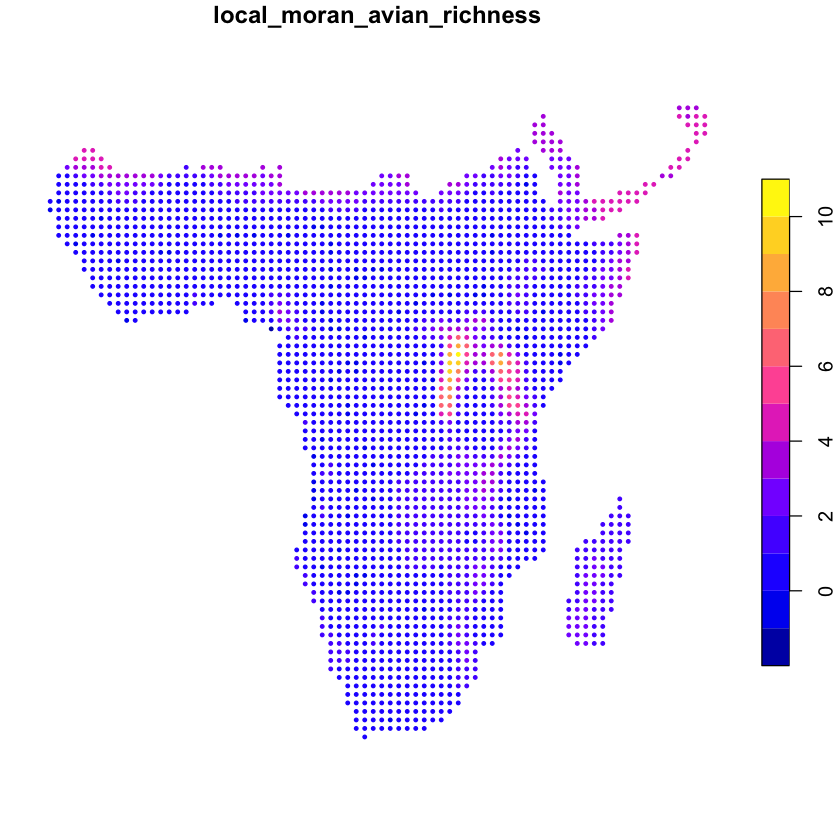

In [23]:
local_moran_avian_richness <- localmoran(data_sf$avian_richness, rook)
data_sf$local_moran_avian_richness <- local_moran_avian_richness[, 'Ii'] # Observed Moran's I
plot(data_sf['local_moran_avian_richness'], cex=0.6, pch=20)

The similar function `localG` just calculates a $z$ statistic showing strength of local autocorrelation.

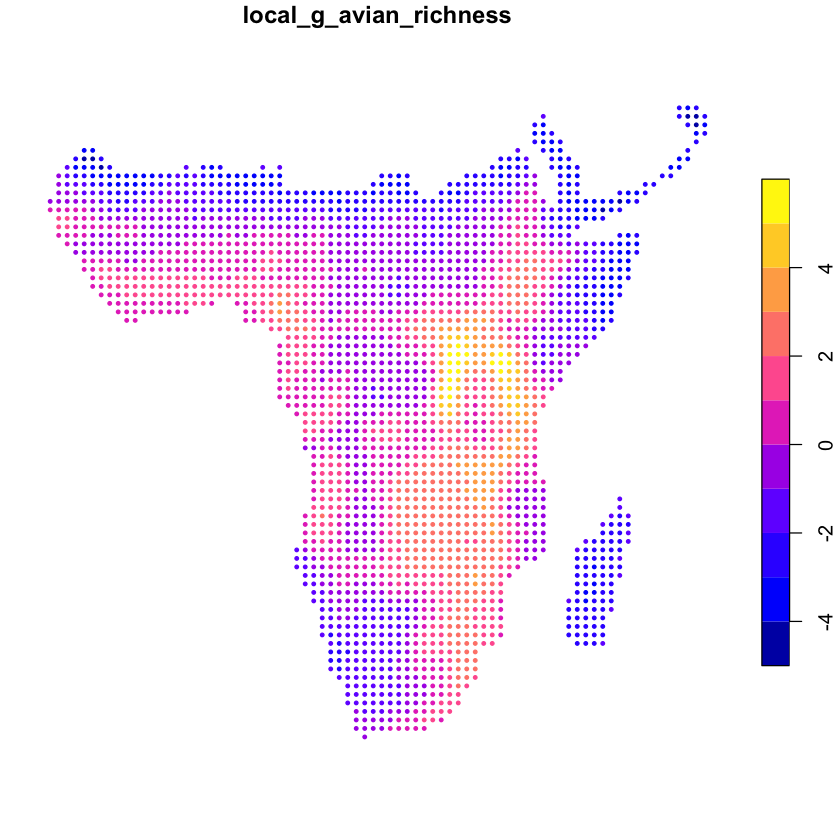

In [24]:
data_sf$local_g_avian_richness <- localG(data_sf$avian_richness, rook)
plot(data_sf['local_g_avian_richness'], cex=0.6, pch=20)

```{admonition} Exploring local spatial autocorrelation
As we might predict, avian richness shows strong positive spatial autocorrelation, which seems to be particularly strong in the mountains around Lake Victoria. Try these measures out on the other variables and neighbourhoods.
```


## Autoregressive models

Our definition of a set of neighbours allows us to fit a spatial autoregressive (SAR) model. This is a statistical model that predicts the value of a response variable in a cell using the predictor variables and values of the response variable in neighbouring cells. This is why they are called autoregressive models: they fit the response variable partly as a response to itself.

They come in many different possible forms. This is a great paper explaining some of the different forms with some great appendices including example R code:

> Kissling, W.D. and Carl, G. (2008), Spatial autocorrelation and the selection of simultaneous autoregressive models. Global Ecology and Biogeography, 17: 59-71. [doi:10.1111/j.1466-8238.2007.00334.x](https://doi.org/10.1111/j.1466-8238.2007.00334.x)

In [25]:
# Fit a simple linear model
simple_model <- lm(avian_richness ~ mean_aet + elev + mean_temp, data=data_sf)
summary(simple_model)


Call:
lm(formula = avian_richness ~ mean_aet + elev + mean_temp, data = data_sf)

Residuals:
    Min      1Q  Median      3Q     Max 
-286.82  -53.00   -1.53   51.95  324.58 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) 198.276692  21.062878   9.414  < 2e-16 ***
mean_aet      0.178391   0.004665  38.238  < 2e-16 ***
elev          0.073595   0.005422  13.573  < 2e-16 ***
mean_temp    -4.508362   0.713118  -6.322 3.05e-10 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 81.24 on 2475 degrees of freedom
Multiple R-squared:  0.4665,	Adjusted R-squared:  0.4659 
F-statistic: 721.4 on 3 and 2475 DF,  p-value: < 2.2e-16


In [26]:
# Fit a spatial autoregressive model: this is much slower and can take minutes to calculate
sar_model <- errorsarlm(avian_richness ~ mean_aet + elev + mean_temp, 
                        data=data_sf, listw=queen)
summary(sar_model)


Call:errorsarlm(formula = avian_richness ~ mean_aet + elev + mean_temp, 
    data = data_sf, listw = queen)

Residuals:
       Min         1Q     Median         3Q        Max 
-218.57762   -9.64130   -0.54812    9.09747  109.78562 

Type: error 
Coefficients: (asymptotic standard errors) 
              Estimate Std. Error z value  Pr(>|z|)
(Intercept) 44.2663338 64.8564135  0.6825   0.49490
mean_aet     0.0581636  0.0070908  8.2027 2.220e-16
elev         0.0485815  0.0067335  7.2149 5.396e-13
mean_temp    3.0505866  1.2710584  2.4000   0.01639

Lambda: 0.99316, LR test value: 6447.6, p-value: < 2.22e-16
Asymptotic standard error: 0.0017541
    z-value: 566.2, p-value: < 2.22e-16
Wald statistic: 320580, p-value: < 2.22e-16

Log likelihood: -11193.01 for error model
ML residual variance (sigma squared): 364.6, (sigma: 19.095)
Number of observations: 2479 
Number of parameters estimated: 6 
AIC: 22398, (AIC for lm: 28844)


We can then look at the **predictions** of those models. We can extract the predicted values for each point and put them into our spatial data frame and then map them.

This method assumes the response is known - see manual page



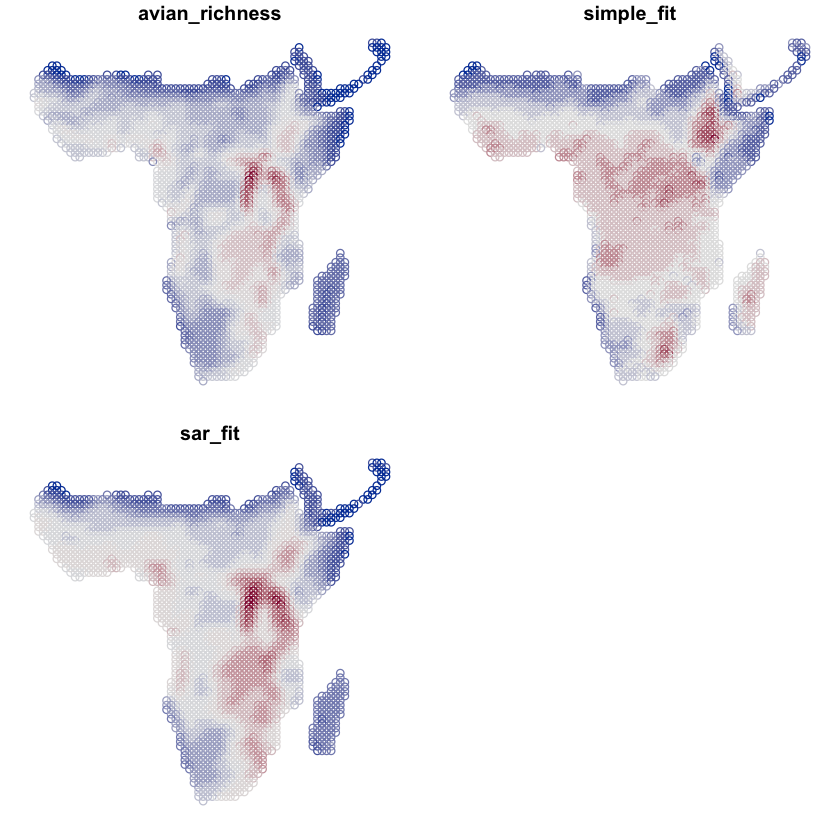

In [27]:
# extract the predictions from the model into the spatial data frame
data_sf$simple_fit <- predict(simple_model)
data_sf$sar_fit <- predict(sar_model)
# Compare those two predictions with the data
plot(data_sf[c('avian_richness','simple_fit','sar_fit')], 
     pal=function(n) hcl.colors(n, pal='Blue-Red'))

We can also look at the **residuals** of those models -  the differences between the prediction and the actual values - to highlight where the models aren't working well. We'll manipulate the colours so negative residuals are blue and positive residuals are red.

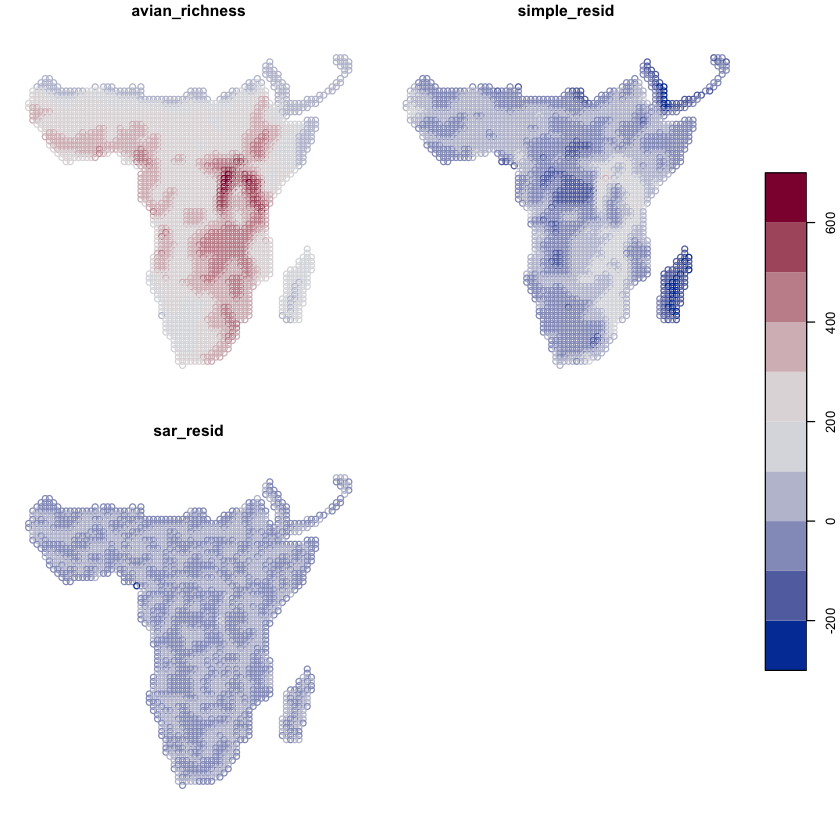

In [28]:
# extract the residuals from the model into the spatial data frame
data_sf$simple_resid <- residuals(simple_model)
data_sf$sar_resid <- residuals(sar_model)
 plot(data_sf[c('avian_richness','simple_resid', 'sar_resid')], 
      pal=function(n) hcl.colors(n, pal='Blue-Red'), key.pos=4)

### Correlograms

Correlograms are another way of visualising spatial autocorrelation. They show how the correlation within a variable changes as the distance between pairs of points being compared increases. To show this, we need the coordinates of the spatial data and the values of a variable at each point.

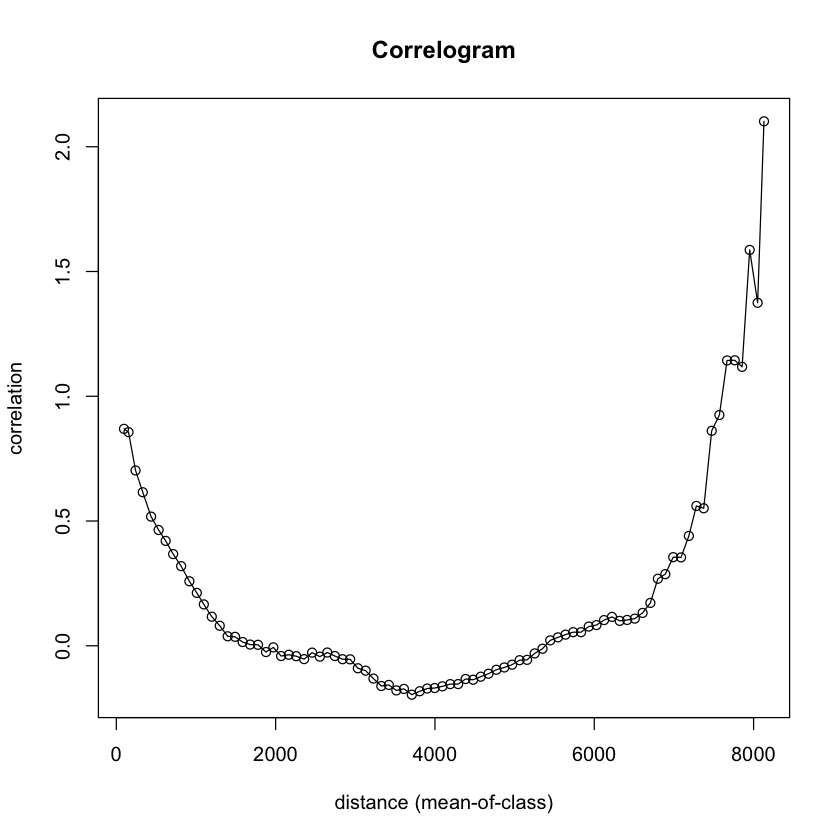

In [29]:
# add the X and Y coordinates to the data frame
data_xy <- data.frame(st_coordinates(data_sf))
data_sf$x <- data_xy$X
data_sf$y <- data_xy$Y

# calculate a correlogram for avian richness: a slow process!
rich.correlog <- with(data_sf, correlog(x, y, avian_richness, increment=cellsize, resamp=0))
plot(rich.correlog)

To explain that a bit further: we take a focal point and then make pairs of the value of that point and all other points. These pairs are assigned to bins based on how far apart the points are: the `increment` is the width of those bins in map units. Once we've done this for all points - yes, that is a lot of pairs! - we calculate the correlations between the sets of pairs in each bin. Each bin has a mean distance among the points in that class.

We can get the significance of the correlations at each distance by resampling the data, but it is a very slow process, which is why the correlograms here have been set not to do any resampling (`resamp=0`).

We can get more control on that plot by turning the object into a data frame. First, we can see that the number of pairs in a class drops off dramatically at large distances: that upswing on the right is based on few pairs, so we can generally ignore it and look at just shorter distances.

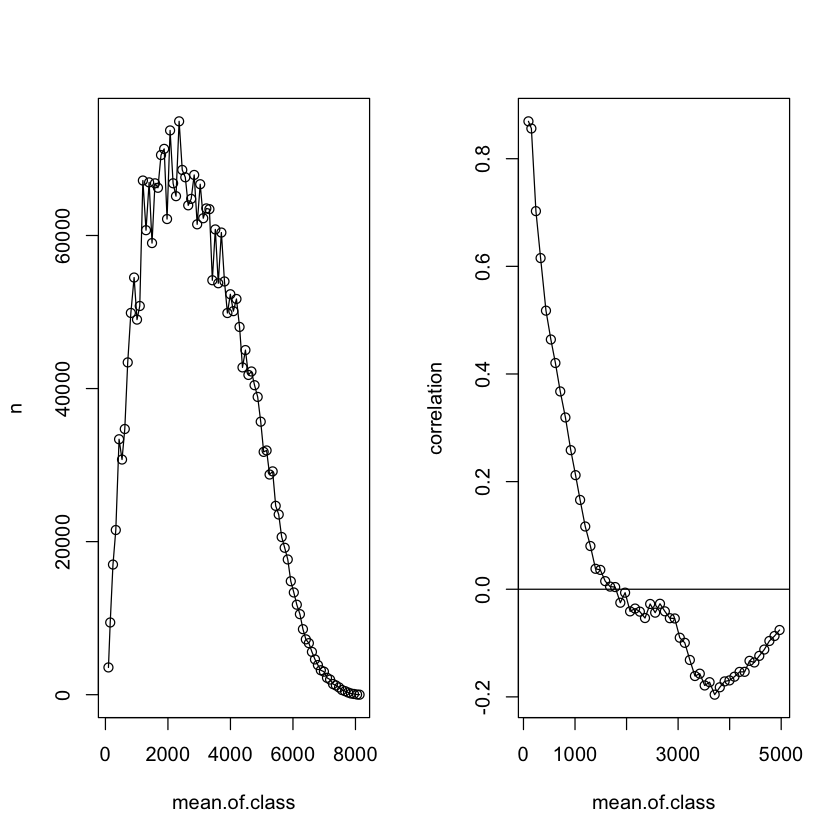

In [30]:
par(mfrow=c(1,2))
# convert three key variables into a data frame
rich.correlog <- data.frame(rich.correlog[1:3])
# plot the size of the distance bins
plot(n ~ mean.of.class, data=rich.correlog, type='o')
# plot a correlogram for shorter distances
plot(correlation ~ mean.of.class, data=rich.correlog, type='o', subset=mean.of.class < 5000)
# add a horizontal  zero correlation line
abline(h=0)

One key use of correlograms is to assess how well models have controlled for spatial autocorrelation by looking at the correlation in the residuals. We can compare our two models like this and see how much better the SAR is at controlling for the autocorrelation in the data.

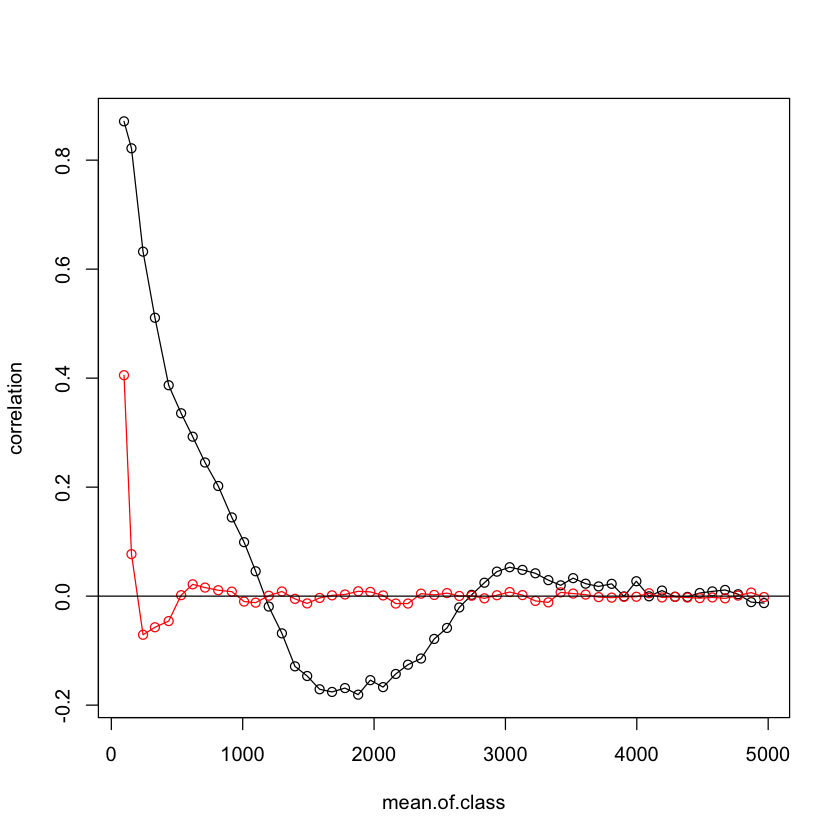

In [31]:
# Calculate correlograms for the residuals in the two models
simple.correlog <- with(data_sf, correlog(x, y, simple_resid, increment=cellsize, resamp=0))
sar.correlog <- with(data_sf, correlog(x, y, sar_resid, increment=cellsize, resamp=0))

# Convert those to make them easier to plot
simple.correlog <- data.frame(simple.correlog[1:3])
sar.correlog <- data.frame(sar.correlog[1:3])

# plot a correlogram for shorter distances
plot(correlation ~ mean.of.class, data=simple.correlog, type='o', subset=mean.of.class < 5000)
# add the data for the SAR model to compare them
lines(correlation ~ mean.of.class, data=sar.correlog, type='o', subset=mean.of.class < 5000, col='red')

# add a horizontal  zero correlation line
abline(h=0)

## Generalised least squares

Generalised least squares (GLS) is an another extension of the linear model framework that allows us to include the expected correlation between our data points in the model fitting. The immediate way it differs from spatial autoregressive models is that it does not use a list of cell neighbourhoods, instead it uses a mathematical function to describe a model of how correlation changes with distance.

The `gls` function works in the same way as `lm` but permits extra arguments, so we can fit the simple model:

In [32]:
gls_simple <- gls(avian_richness ~ mean_aet + mean_temp + elev, data=data_sf)
summary(gls_simple)

Generalized least squares fit by REML
  Model: avian_richness ~ mean_aet + mean_temp + elev 
  Data: data_sf 
       AIC      BIC    logLik
  28858.04 28887.11 -14424.02

Coefficients:
                Value Std.Error  t-value p-value
(Intercept) 198.27669 21.062878  9.41356       0
mean_aet      0.17839  0.004665 38.23824       0
mean_temp    -4.50836  0.713118 -6.32204       0
elev          0.07360  0.005422 13.57341       0

 Correlation: 
          (Intr) mean_t mn_tmp
mean_aet  -0.315              
mean_temp -0.975  0.148       
elev      -0.821  0.184  0.753

Standardized residuals:
       Min         Q1        Med         Q3        Max 
-3.5303243 -0.6523947 -0.0187891  0.6394739  3.9951462 

Residual standard error: 81.24335 
Degrees of freedom: 2479 total; 2475 residual

That looks very like the normal `lm` output - and indeed the coefficients are identical to the same model fitted using `lm` above. One difference is `gls` output includes a matrix showing the correlations between the explanatory variables. If I was being critical, I would say that elevation and temperature are a rather highly correlated and that multicollearity might be a problem (see [Practical 2](/practical_2/practical_2.html)).

To add spatial autocorrelation into the model we have to create a spatial correlation structure. The example below uses the Gaussian model. You can look at `?corGaus` for the equation but essentially this model describes how the expected correlation decreases from an initial value with increasing distance until a range threshold is met - after that the data is expected to be uncorrelated. The constructor needs to know the spatial coordinates of the data (using `form`) and then the other arguments set the shape of the curve. You can set `fixed=FALSE` and the model will then try and optimise the range and nugget parameters, but this can take hours.

In [33]:
# Define the correlation structure
cor_struct_gauss <- corGaus(value=c(range=650, nugget=0.1), form=~ x + y, fixed=TRUE, nugget=TRUE)
# Add that to the simple model - this might take a few minutes to run!
gls_gauss <- update(gls_simple,  corr=cor_struct_gauss)
summary(gls_gauss)

Generalized least squares fit by REML
  Model: avian_richness ~ mean_aet + mean_temp + elev 
  Data: data_sf 
       AIC      BIC    logLik
  24586.56 24615.63 -12288.28

Correlation Structure: Gaussian spatial correlation
 Formula: ~x + y 
 Parameter estimate(s):
 range nugget 
 650.0    0.1 

Coefficients:
               Value Std.Error   t-value p-value
(Intercept) 357.1643  46.27826  7.717755   0.000
mean_aet      0.0533   0.00851  6.257810   0.000
mean_temp    -7.8843   1.60945 -4.898760   0.000
elev          0.0106   0.00929  1.141019   0.254

 Correlation: 
          (Intr) mean_t mn_tmp
mean_aet  -0.165              
mean_temp -0.926  0.045       
elev      -0.878  0.076  0.935

Standardized residuals:
       Min         Q1        Med         Q3        Max 
-2.0344981 -0.0253260  0.6173762  1.1890697  4.3973486 

Residual standard error: 96.62373 
Degrees of freedom: 2479 total; 2475 residual

That output looks very similar but now includes a description of the correlation structure. Note that all of the **model coefficients have changed** and the **significance of the variables** has changed. Elevation is no longer significant when we account for autocorrelation.

We can map the two model predictions

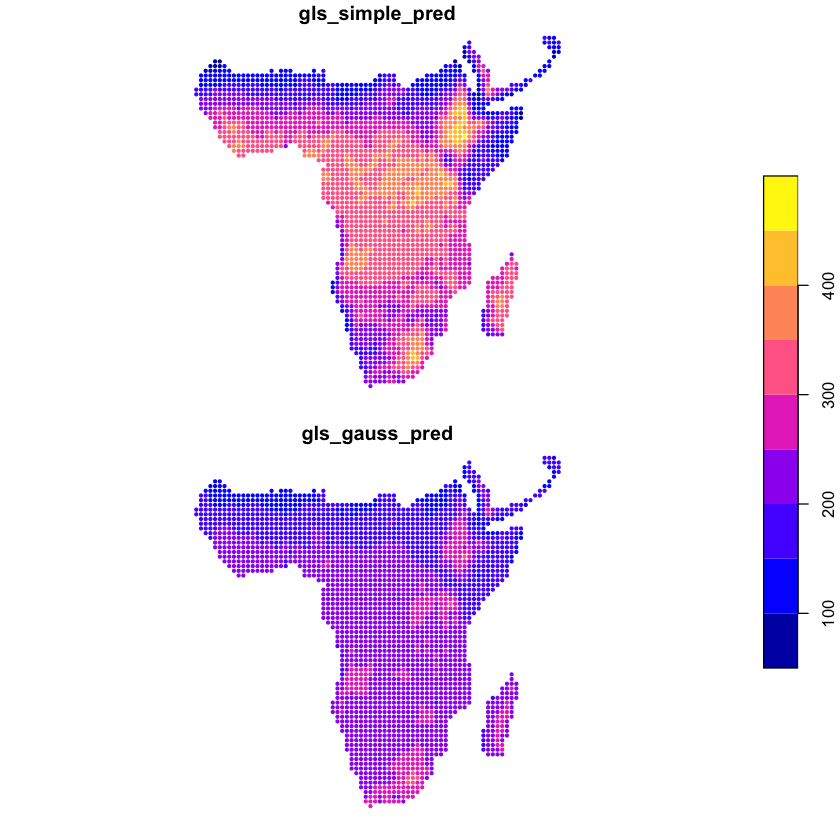

In [34]:
data_sf$gls_simple_pred <- predict(gls_simple)
data_sf$gls_gauss_pred <- predict(gls_gauss)
plot(data_sf[c('gls_simple_pred','gls_gauss_pred')], key.pos=4, cex=0.6, pch=20)

```{admonition} Compare the residual autocorrelation
Using the example at the end of the section on [autoregressive models](autoregressive-models), create this plot comparing the autocorrelation in the residuals from the two GLS models.
```

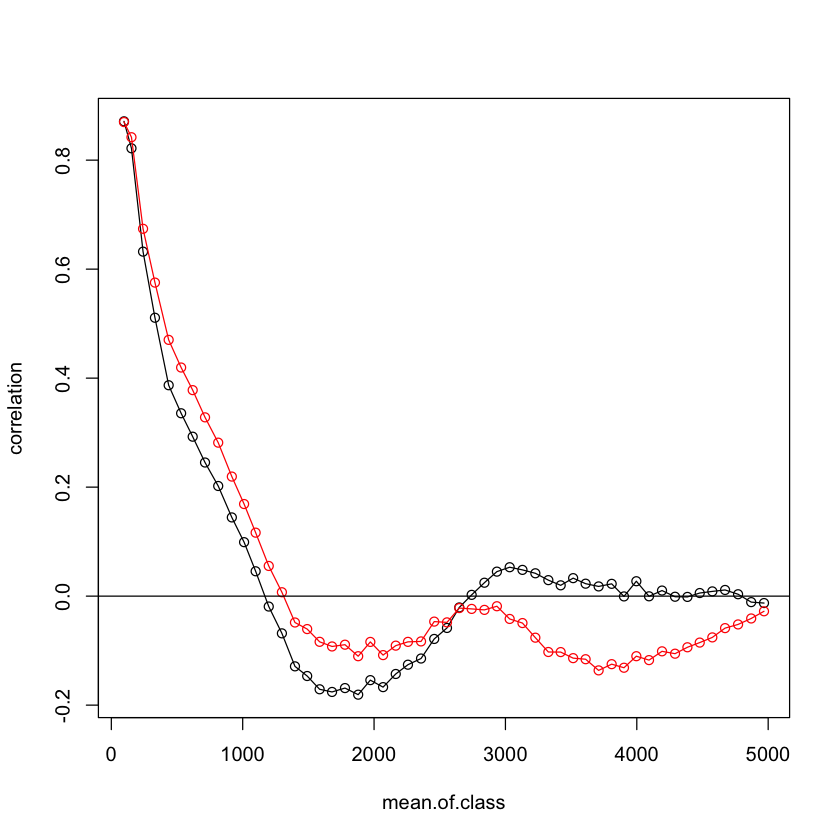

In [35]:
#Extract the residuals
data_sf$gls_simple_resid <- resid(gls_simple)
data_sf$gls_gauss_resid <- resid(gls_gauss)

# Calculate correlograms for the residuals in the two models
simple.correlog <- with(data_sf, correlog(x, y, gls_simple_resid, increment=cellsize, resamp=0))
gauss.correlog <- with(data_sf, correlog(x, y, gls_gauss_resid, increment=cellsize, resamp=0))

# Convert those to make them easier to plot
simple.correlog <- data.frame(simple.correlog[1:3])
gauss.correlog <- data.frame(gauss.correlog[1:3])

# plot a correlogram for shorter distances
plot(correlation ~ mean.of.class, data=simple.correlog, type='o', subset=mean.of.class < 5000)
# add the data for the SAR model to compare them
lines(correlation ~ mean.of.class, data=gauss.correlog, type='o', subset=mean.of.class < 5000, col='red')

# add a horizontal  zero correlation line
abline(h=0)

Oh dear - that is **not the improvement we were looking for**. We can also look at the relationship between observed and predicted richness. It is clear that - although it may be dealing with spatial autocorrelation - this spatial GLS is not a good description of the data! Do not forget that **all models require careful model criticism**!

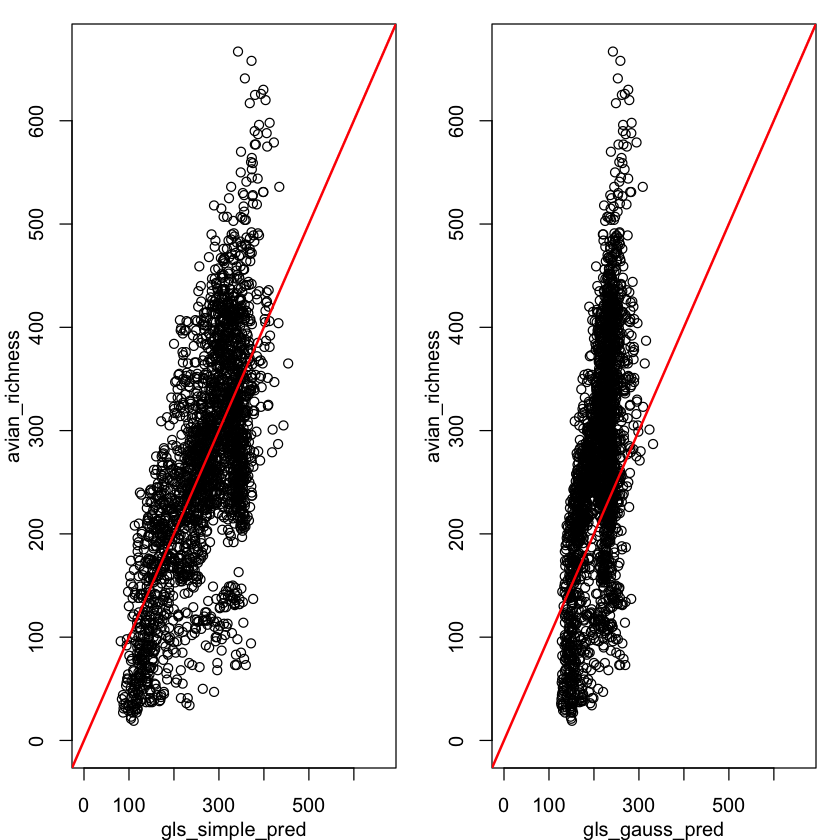

In [36]:
par(mfrow=c(1,2), mar=c(3,3,1,1), mgp=c(2,1,0))
# set the plot limits to show the scaling clearly
lims <- c(0, max(data_sf$avian_richness))
plot(avian_richness ~ gls_simple_pred, data=data_sf, xlim=lims, ylim=lims)
abline(a=0, b=1, col='red', lwd=2)
plot(avian_richness ~ gls_gauss_pred, data=data_sf, xlim=lims, ylim=lims)
abline(a=0, b=1, col='red', lwd=2)

## Eigenvector filtering

This is yet another approach to incorporating spatial structure. In the example below, we take a set of neighbourhood weights and convert them into eigenvector filters using the `meigen` function from `spmoran`. Again, the package vignette is a great place for further data (although the vignette name is a bit unhelpfully generic!)

```r
vignette('vignettes', package='spmoran')
```

```{admonition} Sidebar about package quality

If you look at the details of `spmoran` you will see that it is (currently!) version `0.2.0`. A version number less than 1.0.0 means that the package is in development. It is often a good idea to be wary of in development and infrequently used packages: packages on CRAN have to be formatted correctly so that they build and install cleanly but there is no systematic check that the code they contain works correctly.

In this case, Daisuke Murakami is a co-author of many papers with Daniel Griffith on eigenvector filtering and the quality and detail in the vignette is an *excellent* indication of the care and attention put into the package.

> Murakami, D. and Griffith, D.A. (2015) Random effects specifications in eigenvector spatial
filtering: a simulation study. Journal of Geographical Systems, 17 (4), 311-331.

```

In order to use this, we first need to extract the eigenvectors from our neighbourhood list. We need a different format, so we need to recreate the initial neighbours and then convert those to a weights *matrix* rather than sets of neighbour weights.

In [37]:
# Get the neighbours
queen <- dnearneigh(data_sf, d1=0, d2=sqrt(2) * cellsize + 1)
# Convert to eigenvector filters - this is a bit slow
queen_eigen <- meigen(cmat = nb2mat(queen, style='W'))

 Note:



   cmat is symmetrized by ( cmat + t( cmat ) ) / 2



 836/2479 eigen-pairs are extracted



The `queen_eigen` object contains a matrix `sf` of spatial filters (not the same as the `sf` data frame class!) and a vector `ev` of eigenvalues. Each column in `queen_eigen$sf` shows a different pattern in the spatial structure and has a value for each data point; the corresponding eigenvalue is a measure of the strength of that pattern. 

We'll look at some examples:

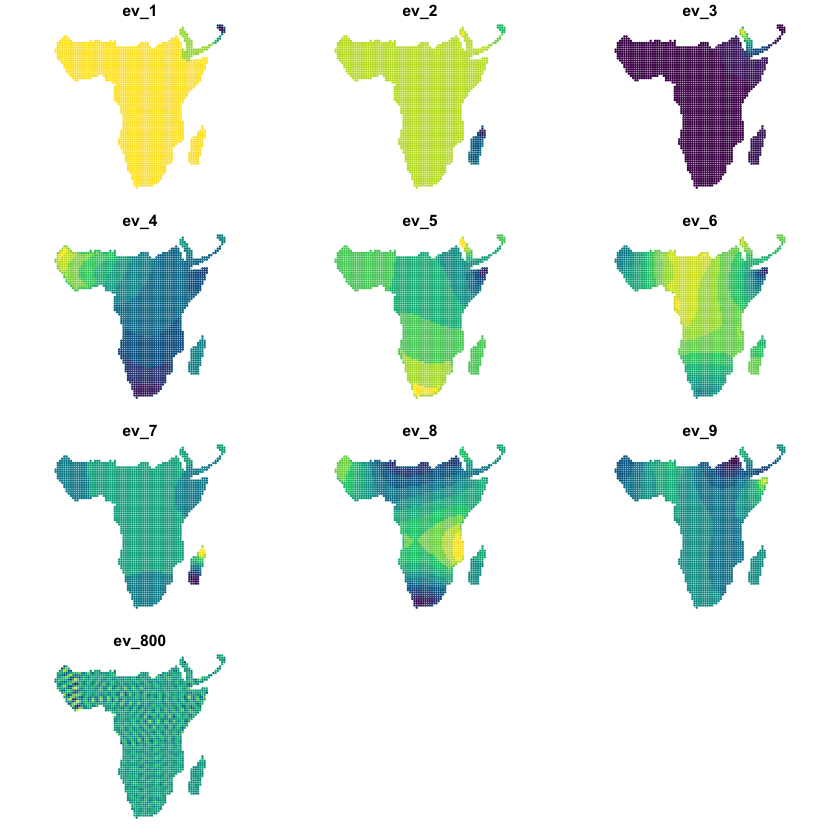

In [38]:
# Convert the `sf` matrix of eigenvectors into a data frame
queen_eigen_filters <- data.frame(queen_eigen$sf)
names(queen_eigen_filters) <- paste0('ev_', 1:ncol(queen_eigen_filters))

# Combine this with the model data frame - note this approach
# for combining an sf dataframe and another dataframe by rows
data_sf <- st_sf(data.frame(data_sf, queen_eigen_filters))

# Visualise 9 of the strongest filters and 1 weaker one for comparison
plot(data_sf[c('ev_1', 'ev_2', 'ev_3', 'ev_4', 'ev_5', 'ev_6', 
               'ev_7', 'ev_8', 'ev_9', 'ev_800')],
     pal=hcl.colors, max.plot=10, cex=0.2)

The `spmoran` package provides a set of more sophisticated (and time-consuming) approaches but here we are simply going to add some eigenvector filters to a standard linear model. We will use the first 9 eigenvectors.

In [39]:
eigen_mod <- lm(avian_richness ~ mean_aet + elev + mean_temp + ev_1 + ev_2 +
                ev_3 + ev_4 + ev_5 + ev_6 + ev_7 + ev_8 + ev_9, data=data_sf)
summary(eigen_mod)


Call:
lm(formula = avian_richness ~ mean_aet + elev + mean_temp + ev_1 + 
    ev_2 + ev_3 + ev_4 + ev_5 + ev_6 + ev_7 + ev_8 + ev_9, data = data_sf)

Residuals:
     Min       1Q   Median       3Q      Max 
-186.443  -49.031    0.535   48.127  315.401 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  2.506e+02  3.536e+01   7.086 1.79e-12 ***
mean_aet     1.443e-01  5.567e-03  25.917  < 2e-16 ***
elev         5.575e-02  6.288e-03   8.867  < 2e-16 ***
mean_temp   -5.142e+00  1.227e+00  -4.190 2.89e-05 ***
ev_1         3.781e+02  7.007e+01   5.396 7.48e-08 ***
ev_2         1.560e+03  7.314e+01  21.333  < 2e-16 ***
ev_3        -1.056e+03  7.256e+01 -14.558  < 2e-16 ***
ev_4        -1.997e+02  1.182e+02  -1.690   0.0912 .  
ev_5         1.557e+02  1.032e+02   1.509   0.1315    
ev_6         1.916e+02  9.099e+01   2.106   0.0353 *  
ev_7         1.508e+02  7.029e+01   2.146   0.0320 *  
ev_8         1.166e+03  7.479e+01  15.585  < 2e-16 ***
ev_9        -3.1

In that output, we do not really care about the coefficients for each filter: those elements are just in the model to control for spatial autocorrelation. We might want to remove filters that are not significant.

Using the tools above, we can look at the residual spatial autocorrelation and predictions from this model.

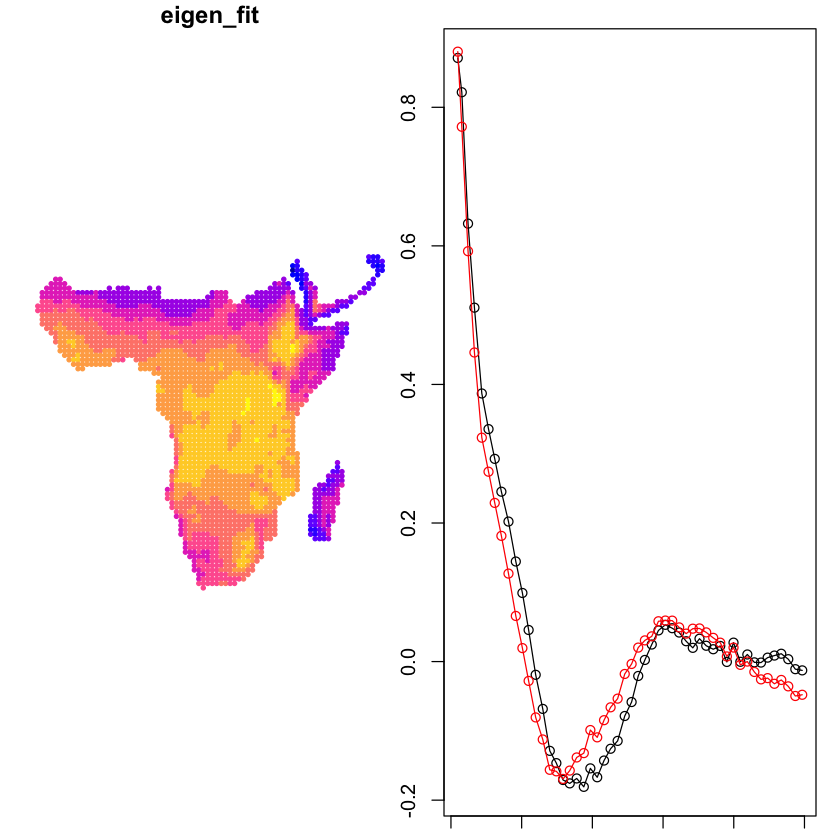

In [40]:
data_sf$eigen_fit <- predict(eigen_mod)
data_sf$eigen_resid <- resid(eigen_mod)

eigen.correlog <- with(data_sf, correlog(x, y, eigen_resid, increment=cellsize, resamp=0))
eigen.correlog <- data.frame(eigen.correlog[1:3])

par(mfrow=c(1,2))
plot(data_sf['eigen_fit'], pch=20, cex=0.7,  key.pos=NULL, reset=FALSE)
# plot a correlogram for shorter distances
plot(correlation ~ mean.of.class, data=simple.correlog, type='o', subset=mean.of.class < 5000)
# add the data for the SAR model to compare them
lines(correlation ~ mean.of.class, data=eigen.correlog, type='o', subset=mean.of.class < 5000, col='red')

That is not much of an improvement either. To be fair to the `spmoran` package, the approach is intended to consider a much larger set of filters and go through a selection process. The modelling functions in `spmoran` do not use the formula interface - which is a bit hardcore - but the code would be as follows. I **do not recommend running** this now - I have no idea of how long it would take to finish but it is at least quarter of an hour and might be days.

```r
# Get a dataframe of the explanatory variables
expl <- data_sf[,c('elev','mean_temp','mean_aet')]
# This retains the geometry, so we need to convert back to a simple dataframe
st_geometry(expl) <- NULL
# Fit the model, optimising the AIC
eigen_spmoran <- esf(data_sf$avian_richness, expl, meig=queen_eigen, fn='aic')
```